## Modeling
### Experiments with Tree-based Scikit-learn models

**Objetivo**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting.

**Conclusions**:


## 1.0 Imports

In [2]:
import sys
import os

sys.path.insert(0,'../..')
from concurrent.futures import ThreadPoolExecutor, as_completed

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
from joblib import load, dump
from scipy.stats import uniform, randint, norm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor


# from src.models.evaluate_model import walk_forward_validation, model_crossval_pipeline

# from src.config import *

### 2.0 Definindo Parâmetros

In [2]:
log_format = "[%(name)s][%(levelname)-6s] %(message)s"
logging.basicConfig(format=log_format)
logger = logging.getLogger("model_experimentation")
logger.setLevel(logging.CRITICAL)

## 3.0 Baseline Testing

In [3]:
def model_testing_pipeline(tunning=False):

    logger.debug("Loading the featurized dataset..")
    stock_df_feat_all = pd.read_csv(os.path.join('../.'+PROCESSED_DATA_PATH, 'processed_stock_prices.csv'), parse_dates=["Date"])
    
    stock_name = 'BBSE3.SA'
    stock_df_feat_all = stock_df_feat_all[stock_df_feat_all["Stock"] == stock_name].copy()#.drop("Stock", axis=1).copy()

    # iterate over the stocks
    validation_report_df = pd.DataFrame()
    stock_errors = []

    n_gas = stock_df_feat_all["Stock"].nunique()
    for idx, stock_name in enumerate(stock_df_feat_all["Stock"].unique()):

        if idx % 100 == 0:
            print(f"Iteration {idx} of {n_gas}...")

        # logger.info("Testing the model for the stock: %s..."%stock_name)
        stock_df_feat = stock_df_feat_all[stock_df_feat_all["Stock"] == stock_name].copy().drop("Stock", axis=1)
        try:
            predictions_df, X_testing_df = test_model_one_shot(
                X=stock_df_feat.drop([model_config["TARGET_NAME"]], axis=1),
                y=stock_df_feat[model_config["TARGET_NAME"]],
                forecast_horizon=model_config['FORECAST_HORIZON'],
                stock_name=stock_name,
                tunning=tunning
            )

            predictions_df["Stock"] = stock_name
            predictions_df["Training_Date"] = dt.datetime.today().date()

            validation_report_df = pd.concat([validation_report_df, predictions_df], axis=0)
        except:
            print(f"Erro na série: {stock_name}")
            stock_errors.append(stock_name)
    
    logger.debug("Writing the testing results dataframe...")
    validation_report_df = validation_report_df.rename(columns={"Forecast": "Price"})
    validation_report_df["Class"] = "Testing"
    print(f"Séries com erro: {stock_errors}")

    validation_report_df.to_csv(os.path.join('../.'+OUTPUT_DATA_PATH, f'validation_stock_prices_{dt.datetime.today().date()}.csv'), index=False)
    return validation_report_df

Iteration 0 of 1...
[0]	validation_0-rmse:13.50673	validation_0-logloss:-692.95545
[10]	validation_0-rmse:0.50700	validation_0-logloss:-714.24286
[20]	validation_0-rmse:0.27726	validation_0-logloss:-714.60836
[30]	validation_0-rmse:0.25640	validation_0-logloss:-714.61956
[40]	validation_0-rmse:0.23203	validation_0-logloss:-714.62014
[50]	validation_0-rmse:0.21535	validation_0-logloss:-714.62045
[60]	validation_0-rmse:0.19790	validation_0-logloss:-714.62051
[70]	validation_0-rmse:0.18471	validation_0-logloss:-714.62073
[80]	validation_0-rmse:0.17490	validation_0-logloss:-714.62081
[90]	validation_0-rmse:0.16157	validation_0-logloss:-714.62096
[99]	validation_0-rmse:0.15383	validation_0-logloss:-714.62107


2024-06-07 11:34:47.609 INFO    utililies: Vizualizing the results...
2024-06-07 11:34:47.928 WARNING utililies: Forecast Figure not Saved!


Séries com erro: []


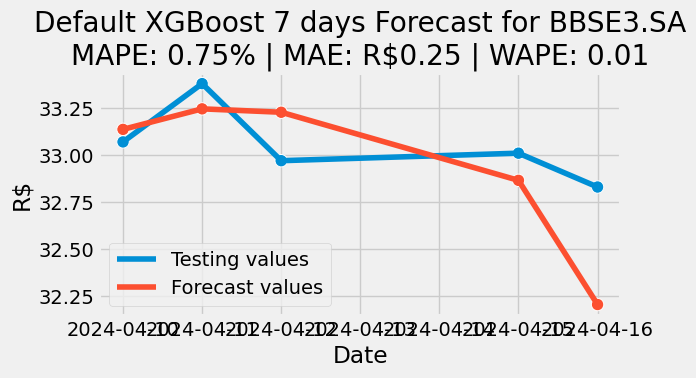

In [4]:
validation_report_df = model_testing_pipeline(tunning=False)

In [5]:
validation_report_df.groupby("Stock").mean()

,Actual,Price,MAPE,MAE,WAPE,RMSE
Stock,,,,,,
BBSE3.SA,33.052,32.93607,0.0075,0.25,0.01,0.32


In [5]:
validation_report_df.groupby("Stock").mean()

,Actual,Price,MAPE,MAE,WAPE,RMSE
Stock,,,,,,
BBSE3.SA,32.939167,31.265273,0.0507,1.67,0.05,1.78


In [1]:
# avg_scores_df = validation_report_df.groupby("Stock", as_index=False).mean()[['Stock', 'MAPE', 'MAE']]
# avg_scores_df['TUNNED'] = 'BASELINE'
# avg_scores_df_tunned = validation_report_df_tunned.groupby("Stock", as_index=False).mean()[['Stock', 'MAPE', 'MAE']]
# avg_scores_df_tunned['TUNNED'] = 'TUNNED'
# avg_scores_df = pd.concat([avg_scores_df, avg_scores_df_tunned], axis=0).reset_index(drop=True)
# avg_scores_df

# avg_scores_df = avg_scores_df.sort_values("MAPE")
# sns.barplot(data=avg_scores_df, y='Stock', x='MAPE', hue='TUNNED')
# plt.grid()
# plt.show()
# avg_scores_df = avg_scores_df.sort_values("MAE")
# sns.barplot(data=avg_scores_df, y='Stock', x='MAE', hue='TUNNED')
# plt.grid()
# plt.show()

## 5.0 HyperOPT Tunning

In [ ]:
# def objective(search_space):
    
#     model = xgb.XGBRegressor(
#         **search_space,
#         verbose=2
#     )
    
#     model.fit(
#         X_train.drop("Date", axis=1),
#         y_train,
#         early_stopping_rounds = 50,
#         eval_metric = ['mae'],
#         eval_set=[[X_train.drop("Date", axis=1), y_train]]
#     )
    
#     y_pred = model.predict(X_test.drop("Date", axis=1))
#     mse = mean_squared_error(y_test, y_pred)
#     mape = mean_absolute_percentage_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     return {'loss': mae, 'status': STATUS_OK}

# # define search space
# search_space = xgboost_hyperparameter_config
# # define algo
# algorithm = tpe.suggest
# # define trials
# #spark_trials = SparkTrials(parallelism=1)
# trials = Trials()

In [ ]:
# best_params = fmin(
#         fn=objective,
#         space=search_space,
#         algo=algorithm,
#         trials=trials,
#         max_evals=10240,
#     )
  
# xgboost_best_param_names = space_eval(search_space, best_params)
# xgboost_best_param_names